# Training of neural network

There is a lot of nuance in training machine learning algorithm. More so for large neural networks.

There are many different update rules, loss functions, activation functions, and network structure to consider. In addition, there are limitations to computers. Large numbers can overflow, small numbers can underflow. Ensuring the implementation is numerical stable is a challenge in of itself.

Luckily frameworks, tools, and library makes it easy nowadays. But it is important to understand how they work and the limitations of them. Especially, if you are designing new network structure, activation functions, training algorithm, etc.

## Numerical stability

A computer has limited amount of memory, as such computers can only store number to a limited size and precision.

Once a number is over the limited size, the computer representation is overflowed.

The limited precision can cause underflow. In addition, limited precision means there is a small error between the computer representation and actual value. In an implementation of an algorithm, this error might accumulate and render the implementation imprecise.

An example of numerical stability is the softmax that was implemented last lesson

$$\text{Softmax}(\vec x) = \frac{e^{\vec x}}{\sum_{x_i \in \vec x}e^{x_i}}$$

In [1]:
import numpy as np

In [2]:
def softmax_unstable(x):
    return np.exp(x) / np.sum(np.exp(x))

In [3]:
softmax_unstable([1000, 700, 1])

/home/user/anaconda3/envs/nlp-course/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  
/home/user/anaconda3/envs/nlp-course/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


array([nan,  0.,  0.])

An input of 1000 is enough to overflow the function. 

Thankfully, numpy will turn overflowed numbers into `-inf`/`inf`. When numpy encounter expressions that can not be evaluate it outputs `nan` or "not a number". This happened since there was an infinity divide by infinity. This is what the two warning message are about.

A stable of version of would look like:

In [4]:
def softmax(x):
    e = np.exp(x - np.max(x))
    return e / np.sum(e)

In [5]:
softmax([1000, 700, 1])

array([1.00000000e+000, 5.14820022e-131, 0.00000000e+000])

This works by shifting the array `x` to zero and negative numbers with `x - np.max(x)`. Exponential of zero and negative numbers are between 1 to 0. Therefore no overflow will occur.

It still works well for large negative numbers.

In [6]:
softmax([-1000000, -1000003, -1000000])

array([0.48785555, 0.0242889 , 0.48785555])

In this case, the stable version is the same as the theoretical version. In some case, this may not be the case. For example, if a algorithm naturally produce a infinity in the theoretical version, we need to modify it for implementation.

Let us show that the implementation is the same as the theoretical version.

The implementation elementwise subtract a the max of the vector from the whole vector. 

Here we will show by adding/subtracting any constant $C$ the formula is still the same as the original:
\begin{align}
\text{Softmax}(\vec x) & = \frac{e^{\vec x + C}}{\sum_{x_i \in \vec x}e^{x_i + C}} \\
 & = \frac{e^{\vec x} \cdot e^C}{\sum_{x_i \in \vec x}e^{x_i} \cdot e^C} \\
 & = \frac{e^C \cdot e^{\vec x}}{e^C \cdot \sum_{x_i \in \vec x}e^{x_i}} \\
 & = \frac{e^{\vec x}}{\sum_{x_i \in \vec x}e^{x_i}}
\end{align}

## Practice

### Exercise 1

Find the numerical stability problem in the cross entropy loss implementation in last lesson, and how to fix it.

In [7]:
class CrossEntropyLoss:
    
    @staticmethod
    def forward(x, t):
        x = softmax(x)
        return -np.log(x) @ t
        
    @staticmethod
    def backward(x, t):
        x = softmax(x)
        return x - t

Answer here

## Vanishing gradients

Vanishing gradients is when the gradient of layers far from the output layer becomes very small. Due to how the update rule works, this means the weights in those layer doesn't change or changes very little each iteration.

Recall in the "Example" section under "The backpropagation partial derivative formula" in the previous lesson, the further away from the output layer the more derivative of activation functions are multiplied to the partial derivative of the loss with respect to the weights in the layer. If the derivative of activation functions is very small, multiplying many of them yields zero or close to zero.

It was briefly mention that sigmoid suffers from vanishing gradient for large networks.

This is because the sigmoid derivative looks like:

In [8]:
import numpy as np
import matplotlib.pyplot as plt

In [9]:
def sigmoid_der(x):
    return np.exp(-x) / (1 + np.exp(-x)) ** 2

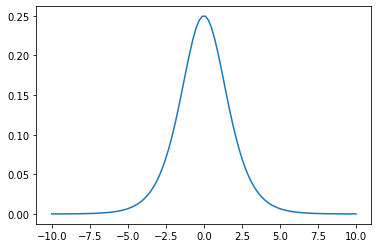

In [10]:
x = np.linspace(-10,10,100)
y = sigmoid_der(x)

plt.figure()
plt.plot(x, y)
plt.show()

Note the maximum is 0.25 at `x=0`. Therefore, the highest possible output is 0.25.

If there are many layers of sigmoid, it is natural for layer far from output to have small gradients. Due to multiplication of many small values.

To prevent vanishing gradient it is best to not use too many activations function with small derivatives in large neural networks.

Using activation function like ReLU, which has derivatives up to 1, can help with vanishing gradients.

## Exploding gradients

This is the opposite of vanishing gradients. When gradient is too large it cause the update rule to make large changes to the parameter, similar to overly large learning rates. We will see how overly large learning rate can cause gradient descent to not converge on any minimum.

Any large changes in the loss surface will cause the corresponding gradient to be large as well.

A common cause is a neural network that has a large amount of layers. Over the layers gradient if enough term greater than 1 is multiplied then the resulting gradient can be massive.

A common solution is to do gradient clipping. Which is restricting how large the gradient can be.

With a threshold $T$:

$$\vec g = \begin{cases}\frac{T \cdot \vec g}{\Vert \vec g \Vert} & \Vert \vec g \Vert \gt T\\ \vec g & \Vert \vec g \Vert \le T\end{cases}$$

Where $\vec g$ is the gradient, $\Vert \vec g \Vert$ is the norm of the gradient.

Norm of a vector is the magnitude of the vector. 

The most common being Euclidean norm:

$\vec x = \sqrt{\sum_i x_i^2} = \sqrt{x_1^2 + x_2^2 + \dots + x_n^2}$

In other words, norm is how large a vector is. So what gradient clipping is doing should be intuitive, if the gradient is too large, than make it smaller.

Or more precisely if the norm of gradient is larger than threshold, then adjust it norm equal the threshold.

In [11]:
def gradient_clipping(g, T):
    g_norm = np.linalg.norm(g)
    if g_norm > T:
        g = T * g / g_norm
    return g

If the magnitude of the vector is not larger than the threshold then nothing happens:

In [12]:
gradient_clipping(np.array([1.0, 1.0, 1.0, 1.0]), 2)

array([1., 1., 1., 1.])

If the magnitude is too large then reduce the value in the vector

In [13]:
gradient_clipping(np.array([1.1, 1.0, 1.0, 1.0]), 2)

array([1.07221439, 0.97474036, 0.97474036, 0.97474036])

Let us plot the norm of gradient before and after gradient clipping:

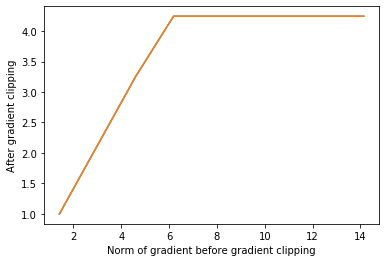

In [14]:
T = 6

i = np.linspace(1, 10, 9)
grad = np.array([i, i]).T

x = []
y = []
for g in grad:
    x.append(np.linalg.norm(g))
    y.append(gradient_clipping(g, T))

plt.figure()
plt.xlabel("Norm of gradient before gradient clipping")
plt.ylabel("After gradient clipping")
plt.plot(x, y)
plt.show()

What gradient clipping is doing is if gradient norm is larger than the threshold, then modify the gradient so that the norm equals to the threshold.

## Gradient descent in practice

Recall the gradient descent update rule in backpropagation:

$\Delta \vec w = - \eta \nabla E$

Where $\eta$ is the learning rate, $\nabla E$ is the gradient of loss, and $\vec w$ is the weights.

This is for updating weights. Or a more general version for updating model parameter $\theta$:

$\Delta \vec \theta = - \eta \nabla E$

By convention, $\theta$ is the general symbol for any model parameter, e.g., weights, biases, and any other tunable parameters in the model.

But gradient descent can also refer to its more general form for optimization problems.

Say we want to find the input $a$ that yields the minimum output of the function $f(a)$, and $f(\cdot)$ is differentiable. 

In other words, find $\hat a$: 

$\hat a = \text{argmax}_a f(a)$

Then gradient descent can help by with iterating with this update rule:

$a_{n+1} = a_{n} - \eta \nabla f(a_{n})$

with $\eta$ being the learning rate.

or with the assignment operator $\leftarrow$:

$a \leftarrow a - \eta \nabla f(a)$

In backpropagation, we were finding the weight that yields the minimum loss (difference of output and target).

Now we will find the $a$ that gives the minimum of $f(a) = a^2$ to demonstrate gradient descent in practice.

The derivative of $f(a)$ is $2x$, so the update rule is:

$$a \leftarrow a - 2 \cdot \eta \cdot x$$

In [15]:
def f(a): 
    return a ** 2

def f_der(a):
    return 2 * a

In [16]:
class GradientDescent:
    
    def __init__(self, eta):
        self.eta = eta
    
    def __call__(self, x, der):
        return x - self.eta * der

Let us plot the $f(a) = a^2$ function first:

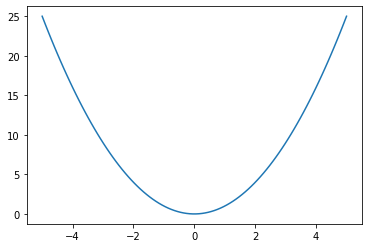

In [17]:
x = np.linspace(-5,5,100)
y = f(x)
plt.figure()
plt.plot(x, y)
plt.show()

Let us plot the gradient descent process.

In [18]:
def plot_update(x, func, func_der, update_rule, start_point, iterations, label=None):
    plt.figure()
    
    # Plot the function
    y = func(x)
    plt.plot(x, y)
    
    # Plot the starting point
    a = start_point
    plt.plot(a, func(a), 'og', markersize=8, label="starting point")

    # Plot the updates
    x = []
    for _ in range(iterations):
        x.append(a)  # Store past a to plot line
        
        der = func_der(a)
        a = update_rule(a, der)

    x = np.array(x)
    y = func(x)
    plt.plot(x, y, 'r', label=label)

    plt.legend()
    plt.show()

Say the $a$ is initialize to $4$ and the learning rate is set to $0.25$.

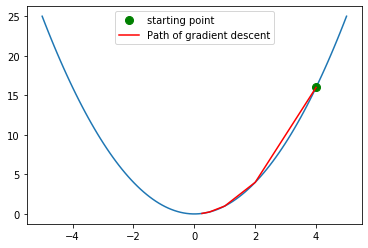

In [19]:
gradient_descent = GradientDescent(0.25)

x = np.linspace(-5, 5, 100)
plot_update(x, f, f_der, gradient_descent, 4, 5, "Path of gradient descent")

With learning rate of 1, it seems the value of $a$ "slides" down into the minimum.

In theory, gradient descent will always converge with a proper learning rate.

Let us try a learning rate of $0.75$.

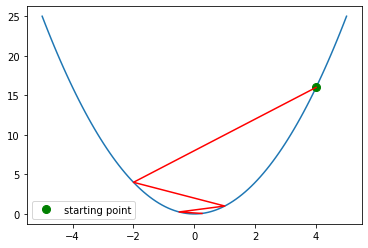

In [20]:
gradient_descent = GradientDescent(0.75)

x = np.linspace(-5, 5, 100)
plot_update(x, f, f_der, gradient_descent, 4, 5)

It still converge.

This time it jump from $4$ to $-2$, then $1$, etc.

It overshoot the minimum each time.

This is the other case where gradient descent works.

Let us try a learning rate of $1.1$:

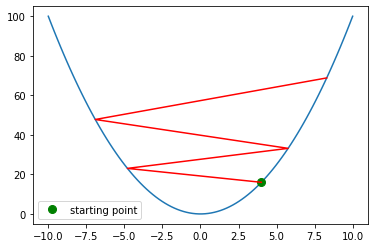

In [21]:
gradient_descent = GradientDescent(1.1)

x = np.linspace(-10, 10, 100)
plot_update(x, f, f_der, gradient_descent, 4, 5)

This time the gradient descent did not converge. 

The value of $a$ went from 4 to -5 to 6 and so on. In other words, it actually got farther from away the minimum.

With a too large learning rate, it would never converge.

Let try minimizing the function: $g(a)= 3a^4 - 16a^3 + 18a^2$

In [22]:
def g(a):
    return 3 * a ** 4 - 16 * a ** 3 + 18 * a **2

def g_der(a):
    return 12 * a ** 3 - 48 * a ** 2 + 36 * a

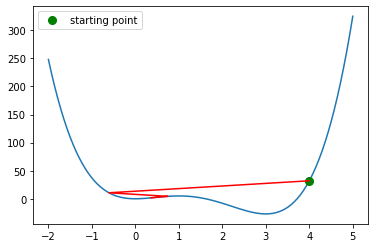

In [23]:
gradient_descent = GradientDescent(0.032)

x = np.linspace(-2, 5, 100)
plot_update(x, g, g_der, gradient_descent, 4, 5)

In the case of multiple local minimum, the gradient descent may end up in a local minimum.

It is always possible that gradient descent converges on a bad local minimum.

### What does it mean for neural network?

In above the function has one parameter so the function is a curve. For modern neural network, there are often millions of parameters or more, so the loss function is a high dimensional surface.

The loss function of a neural network will have a massive amount of local minimums, during training it is 
possible for the gradient descent to jump around these local minimums and never converge on one local minimum.

Since different local minimums have different loss value, it is possible to end up with a local minimum with high loss value after a set training iteration.

Generally, we save the best performing set of parameters during training, rather than the parameter of the final iteration for this reason.

### Saving best model

So we want to save the best performing set of parameters during training. This will require a method to evaluate the model.

To prevent overfitting we need a different set of data from training data, just like test data is different from training data.

This data is called the validation data.

After every set amount of iterations, the network is tested against the validation data. The best performing set of parameter is saved. At the end of training, the best model is the final model.

## Update rules / Optimizer

When using fix learning rate it is possible to have the model diverge. Since the learning rate may to suitable to local minimums at the start of training, but unsuited for local minimums encountered later on.

![loss_learning_rate.png](img/loss_learning_rate.png)

There are other gradient descent based optimization algorithm, which fix some problems with the original gradient descent.


### Local minimums

As mentioned before, gradient descent is only guarantee to converge on a local minimum (with a proper learning rate). That local minimum might be a bad one (high function output value), or a good one (low function output value).

One idea is to add the concept of momentum to gradient descent so it might escape from shallow local minimums.

Continuing using function $g(\cdot)$ as example: $g(a)= 3a^4 - 16a^3 + 18a^2$

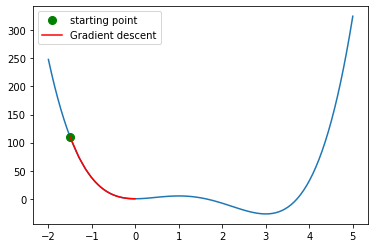

In [24]:
gradient_descent = GradientDescent(0.001)

x = np.linspace(-2, 5, 100)
plot_update(x, g, g_der, gradient_descent, -1.5, 100, "Gradient descent")

#### Gradient descent with momentum

In physics, object in motion stays in motion. We want to apply this general concept to gradient descent, but not the exact physical law.

\begin{align}
m &\leftarrow \gamma m + \eta \nabla E\\
\theta &\leftarrow \theta - m
\end{align}

Where $m$ is the momentum term, $\gamma$ is a decay for $m$. Recall that $\eta$ is the learning rate, $\nabla E$ is the gradient of loss.

The momentum term $m$ the sum of current and past gradients, with a decay rate $\gamma$, which is usually set to $0.9$.

In [25]:
class GradientDescentMomentum:
    
    def __init__(self, eta, gamma):
        self.eta = eta
        self.gamma = gamma
        self.m = 0

    def __call__(self, x, der):
        self.m = self.gamma * self.m + self.eta * der
        return x - self.m       

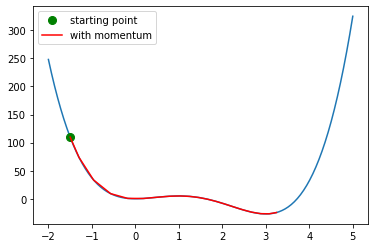

In [26]:
gdm = GradientDescentMomentum(0.001, 0.9)

x = np.linspace(-2, 5, 100)
plot_update(x, g, g_der, gdm, -1.5, 20, "with momentum")

In this plot, the local minimum is overcame with momentum.

Adding "momentum" to gradient descent enable it to deal with series of small valleys and hills of local minimums and local maximums. Since gradient descent with momentum would keep on moving in the general direction of the past gradients.

In three or higher dimensional space, it can also lead to less oscillation.

Let us visualize the difference of with and without momentum in three dimensional space.

The function will be oval shaped bowl with ripples.

In [27]:
from mpl_toolkits.mplot3d import Axes3D

In [28]:
def ripple(x, y):
    return np.sin((0.1 * x) ** 2 + (0.2 * y) ** 2) + (0.2 * x) ** 2 + (0.2 * y) ** 2

def ripple_der(x, y):
    x_der = 0.02 * x * np.cos(0.01 * x ** 2 + 0.04 * y ** 2) + 0.08 * x
    y_der = 0.08 * y * np.cos(0.01 * x ** 2 + 0.04 * y ** 2) + 0.08 * y
    return x_der, y_der

In [29]:
# Enable interactive plots from this point onward.
%matplotlib notebook

<IPython.core.display.Javascript object>


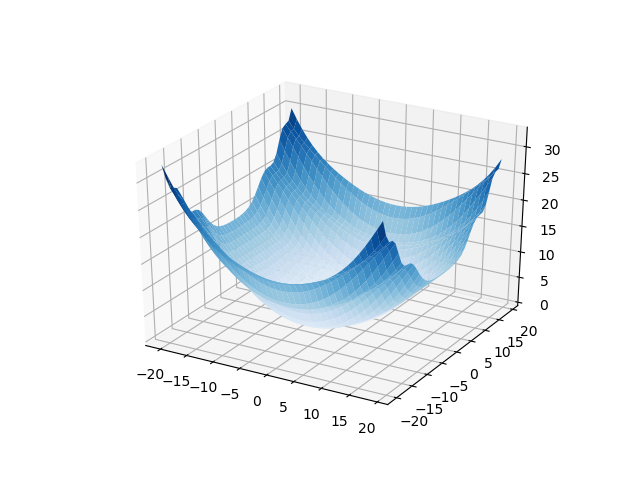

In [30]:
X = np.arange(-20, 20, 1)
Y = np.arange(-20, 20, 1)
X, Y = np.meshgrid(X, Y)
Z = ripple(X, Y)

# Plot the surface.
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z, cmap="Blues")
plt.show()

**If you rerun the code, you can click and drag this plot to rotate it.**

Visualization of this function in top-down view with colormap:

<IPython.core.display.Javascript object>


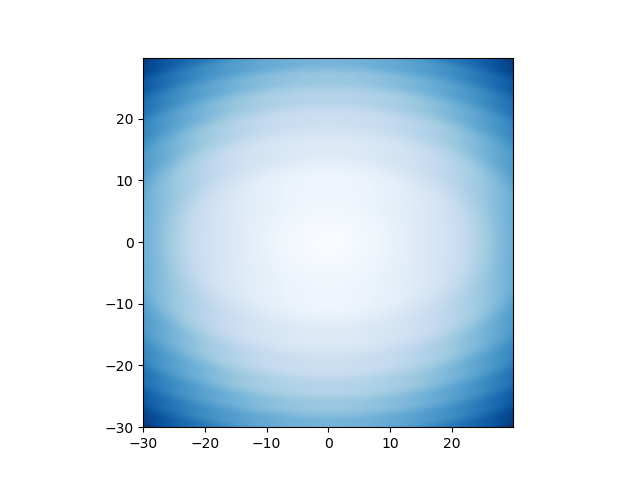

In [31]:
X = np.arange(-30, 30, 0.1)
Y = np.arange(-30, 30, 0.1)
X, Y = np.meshgrid(X, Y)
Z = ripple(X, Y)

# Plot
plt.figure()
plt.imshow(Z, cmap="Blues", extent=(X[0][0], X[-1][-1], Y[0][0], Y[-1][-1]))
plt.show()

There are ripples consist of local minimum and local maximum.

Let us plot performing gradient descent on this surface:

In [32]:
def cmap_plot_update(X, Y, func, func_der, update_rule, starting_x, starting_y, iterations, label=None):
    plt.figure()
    
    # Plot the function
    X, Y = np.meshgrid(X, Y)
    Z = func(X, Y)
    plt.imshow(Z, cmap="Blues", extent=(X[0][0], X[-1][-1], Y[0][0], Y[-1][-1]))
    
    # Plot the starting point
    x = starting_x
    y = starting_y
    plt.plot(x, y, 'og', markersize=8, label="starting point")

    # Plot the updates
   # Update
    xs = []
    ys = []
    for _ in range(iterations):
        xs.append(x)
        ys.append(y)
        
        x_der, y_der = func_der(x, y)
        x, y = update_rule(np.array([x, y]), np.array([x_der, y_der])).tolist()
    
    xs = np.array(xs)
    ys = np.array(ys)
    plt.plot(xs, ys, 'r', label=label)

    plt.legend()
    plt.show()

<IPython.core.display.Javascript object>


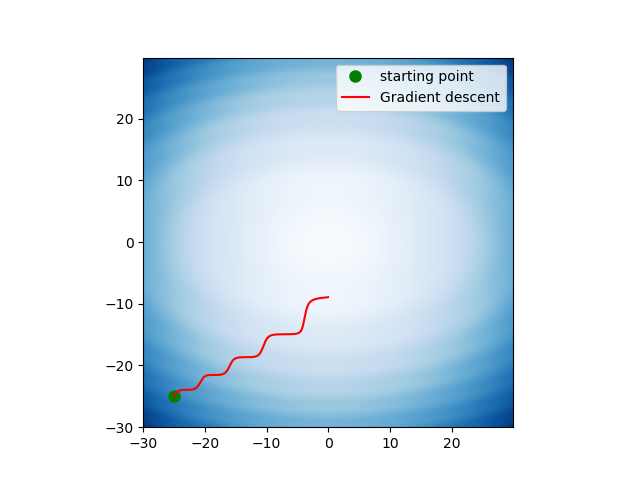

In [33]:
gradient_descent = GradientDescent(0.1)

X = np.arange(-30, 30, 0.1)
Y = np.arange(-30, 30, 0.1)
cmap_plot_update(X, Y, ripple, ripple_der, gradient_descent, -25, -25, 1000, "Gradient descent")

The path of gradient descent has some oscillations due to the oval shape ripples. Also it did not reach the global minimum (0, 0).

<IPython.core.display.Javascript object>


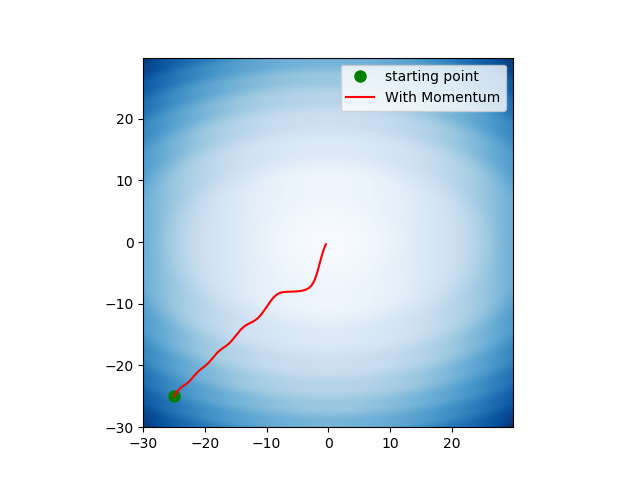

In [34]:
gdm = GradientDescentMomentum(0.01, 0.9)

X = np.arange(-30, 30, 0.1)
Y = np.arange(-30, 30, 0.1)
cmap_plot_update(X, Y, ripple, ripple_der, gdm, -25, -25, 500, "With Momentum")

Using momentum, there are less oscillations, and it reached the global minimum.

By accumulating momentum, gradient descent moves in the general direction of past movements. Think it like the direction of movement is being averaged.

### Saddle point

Critical points is where the gradient of a function is zero or undefined. Since the network and loss function we are dealing with have defined derivatives within the input space, we are only considering zero value gradients.

In two-dimensional space, there is only two types of critical points: a minimum or a maximum.

However, in higher dimensional space there can be another type of critical point called the saddle point.

It is called a saddle point with because it looks like a saddle.

In [35]:
def saddle(x, y):
    return x ** 2 - y ** 2

def saddle_der(x, y):
    return x / 2, -y / 2

<IPython.core.display.Javascript object>


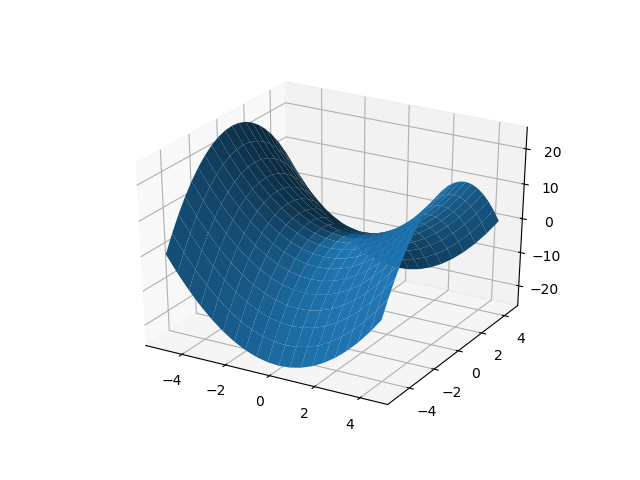

In [36]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Make data.
X = np.arange(-5, 5, 0.5)
Y = np.arange(-5, 5, 0.5)
X, Y = np.meshgrid(X, Y)
Z = saddle(X, Y)

# Plot the surface.
ax.plot_surface(X, Y, Z)
plt.show()

The formula for this surface is: $z = x^2 - y^2$

At the point $(0, 0, 0)$, the gradient is 0.

Since the gradient is 0, it is possible for gradient descent to be stuck there.

Let us see how well gradient descent deal with saddle point.

In [37]:
def plot_update_3d(X, Y, func, func_der, update_rule, starting_x, starting_y, iterations, label=None):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    
    # Plot the surface.
    X, Y = np.meshgrid(X, Y)
    Z = func(X, Y)
    ax.plot_wireframe(X, Y, Z)
    
    # Starting Point
    x = starting_x
    y = starting_y
    z = func(x, y)
    ax.scatter(x, y, z, s=80, c='g', label="starting point")
    
    # Update
    xs = []
    ys = []
    for _ in range(iterations):
        xs.append(x)
        ys.append(y)
        
        x_der, y_der = func_der(x, y)
        x, y = update_rule(np.array([x, y]), np.array([x_der, y_der])).tolist()
        
        if func(x, y) < np.min(Z):
            # Stop when point moved outside the plot
            break
    
    xs = np.array(xs)
    ys = np.array(ys)
    zs = func(xs, ys)    
    ax.plot(xs, ys, zs, c='r', linewidth=3, label=label)
    ax.set_xlabel('Parameter X')
    ax.set_ylabel('Parameter Y')
    ax.set_zlabel('Loss')

    fig.legend()
    fig.show()

For saddle points with certain starting points, gradient_descent may get stuck.

<IPython.core.display.Javascript object>


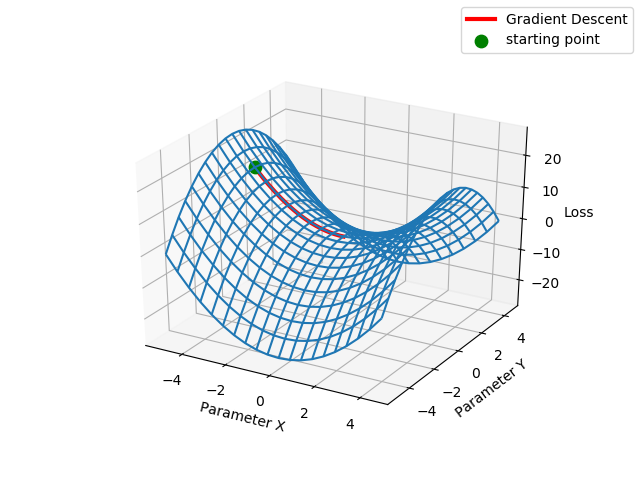

In [38]:
gradient_descent = GradientDescent(0.1)

X = np.arange(-5, 5, 0.5)
Y = np.arange(-5, 5, 0.5)
plot_update_3d(X, Y, saddle, saddle_der, gradient_descent, -4, 0, 500, "Gradient Descent")

Gradient descent is stuck at the saddle point.

However, stochastic gradient descent can escapes the saddle point.

### Loss surface

The loss surface is the plot of loss on one axis and all tunable parameters on their own axes. 

If there is one million tunable parameter then the loss surface is the plot with one million and one axes. So it is generally in very high dimensional space. However, we generally try to visualize it in three-dimensional space, like above examples.

By the way, the loss surface generally refers to the surface from by the sum of the loss over the entire data (whether training, or testing).

### Randomness of stochastic gradient descent 

Since gradient descent is perform on the whole data, it follows the reverse direction of the gradient of the loss surface.

However, stochastic gradient descent is perform on a single case of data. So it doesn't necessary follow the reverse direction of the gradient of the loss surface. Rather, it follows the gradient of the loss surface of a single case of data.

This cause stochastic gradient descent to move in "random" direction where plotted on the loss surface of the whole data.

![stochastic_loss_surface.png](img/stochastic_loss_surface.png)

The arrows are the gradients. Note for stochastic gradient descent the gradient used is the orange curve, or loss of single data.

As we can see the stochastic gradient descent can perform "random jumps". In practice, these "random jumps" are good for escaping local minimums and saddle points.

It is generally believed that loss surface in modern neural networks are filled with saddle points. Being able to quickly escape a saddle point is an important aspect of update rule.

Side note: Stochastic gradient descent is so named because, it randomly select a single case of data or shuffle the dataset. So a element of randomness is introduced.

#### Implementation

We will emulate stochastic gradient descent by adding in noise to derivatives. 

**To be clear, this is not how real stochastic gradient descent works.**

In [39]:
def emulate_stochastic(update_rule, var):
    def wrapper(x, der):
        der = np.random.normal(der, var)
        return update_rule(x, der)
    return wrapper

<IPython.core.display.Javascript object>


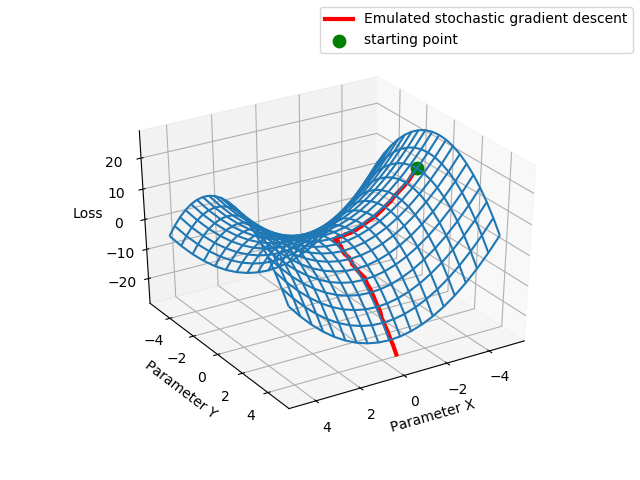

In [40]:
gradient_descent = GradientDescent(0.1)
sgd = emulate_stochastic(gradient_descent, 0.2)

X = np.arange(-5, 5, 0.5)
Y = np.arange(-5, 5, 0.5)
plot_update_3d(X, Y, saddle, saddle_der, sgd, -4, -0, 500, "Emulated stochastic gradient descent")

With the randomness from stochastic gradient descent, it can escape the saddle point. 

## Per-parameter learning rate

One problem with the update rule introduced is every parameter in the model have the same learning rate. After all, a learning rate may be too small for one parameter and too large for another.

### AdaGrad

The idea of [AdaGrad](http://www.jmlr.org/papers/volume12/duchi11a/duchi11a.pdf) is that parameter with frequent update should have smaller learning rate and parameter with sparse update should have larger learning rate.

To accomplish that, the learning rate for each parameter is divided by the square root of sum of squared past gradient of that parameter.

Instead of $\eta$ as the learning for parameter $\vartheta_t$ at time step $t$ the learning rate becomes:

$$\frac{\eta}{\sqrt{\sum_{i=0}^{t}(\frac{\partial E_{i}}{\partial \vartheta_i})^2}}$$

Since it is possible for $\frac{\partial E_{i}}{\partial \vartheta_i}$ to be zero, a small constant $\epsilon$ is added to prevent division by zero.

The update rule for all tunable parameters $\theta$:

$$\theta_{t+1} = \theta_t - \frac{\eta}{\sqrt{\epsilon + \sum_{i=0}^{t}{(\nabla E_i)^2}}} \odot \nabla E_t$$

Where $\theta_t$ is all the parameters at time step $t$, $\nabla E_t$ is the gradient of loss at time step $t$, $\epsilon$ is a small constant. Element-wise multiplication is denoted with $\odot$.

A common value for $\epsilon$ is $10^{\text{-}8}$.

This is based on the theoretical version where $\sum_{i=0}^{t}{(\nabla E_i)^2}$ is replace with matrix $G_t =  \sum_{i=0}^{t} \nabla E_i \otimes \nabla E_i$. Where $\otimes$ is the vector outer product.

The full formula becomes:

$$\theta_{t+1} = \theta_t - \frac{\eta}{\sqrt{\epsilon + G_t}} \odot \nabla E_t$$

Where $\odot$ is the matrix-vector product.

While this version has good theoretical properties, the vector outer product is costly computation-wise.

In [41]:
class AdaGrad:
    
    def __init__(self, eta, epsilon):
        self.eta = eta
        self.eps = epsilon
        self.G = 0
    
    def __call__(self, x, der):
        self.G += der ** 2
        return x - der * self.eta / np.sqrt(self.eps + self.G)

<IPython.core.display.Javascript object>


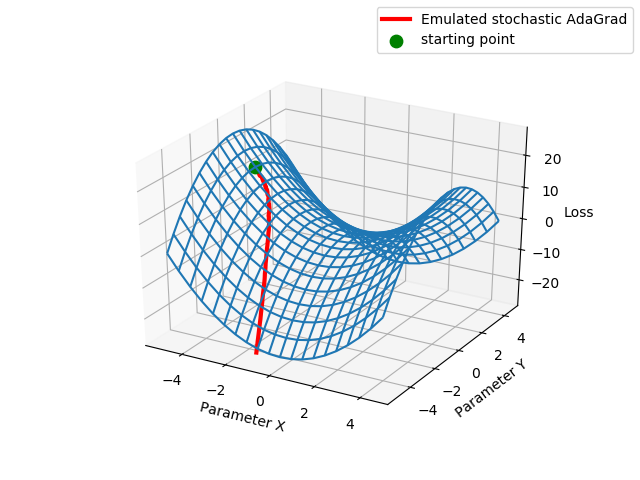

In [42]:
adagrad = AdaGrad(0.1, 1e-8)
emu_adagrad = emulate_stochastic(adagrad, 0.2)

X = np.arange(-5, 5, 0.5)
Y = np.arange(-5, 5, 0.5)
plot_update_3d(X, Y, saddle, saddle_der, emu_adagrad, -4, -0, 500, "Emulated stochastic AdaGrad")

Saddle points is a one of an example of difference in parameter sensitivity. The parameter Y need a much higher learning rate than X in this case.

By comparing with emulated stochastic gradient descent, we can see AdaGrad does provide a higher learning rate to Y .

The main drawback of AdaGrad is its learning rate can decrease very fast with a few large gradients in the past.

Also learning rate in AdaGrad can only decrease.

Later update rules fix these two problems.

### RMSprop

Since the $G_t$ in AdaGrad can only increase with time, the learning rate can only decrease with time. To amend this problem, RMSprop adds a decay rate.

$$G_t = \gamma G_{t-1} + (1 - \gamma) (\nabla E_t) ^ 2$$

$$\theta_{t+1} = \theta_t - \frac{\eta}{\sqrt{\epsilon + G_t}} \odot \nabla E_t$$

Where $\gamma$ is a decay rate smaller than 1, and $\odot$ is vector element-wise multiplication.

A common value for $\gamma$ is $0.9$.

With a decay rate the influence of past gradients approaches zero as time goes on. This makes the learning rate to not decrease too aggressively.

In [43]:
class RMSprop:
    
    def __init__(self, eta, epsilon, gamma):
        self.eta = eta
        self.eps = epsilon
        self.gamma = gamma
        self.G = 0
        
    def __call__(self, x, der):
        self.G = self.gamma * self.G + (1 - self.gamma) * (der ** 2)
        return x - der * self.eta / np.sqrt(self.eps + self.G)        

Since the only difference between AdaGrad and RMSprop is the addition of decay rate $\gamma$, we can compare them to see how much decay rate fixes the problem of rapid and monotonically decreasing learning rate.

In [44]:
learning_rate = 0.1
iterations = 2000
epsilon = 1e-8
gamma = 0.9

<IPython.core.display.Javascript object>


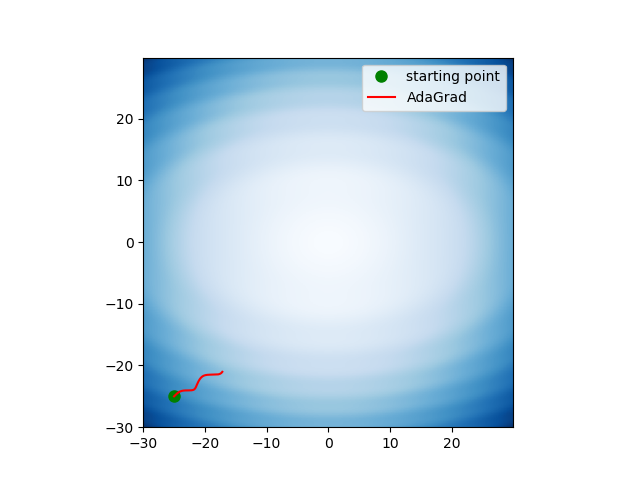

In [45]:
adagrad = AdaGrad(learning_rate, epsilon)

X = np.arange(-30, 30, 0.1)
Y = np.arange(-30, 30, 0.1)
cmap_plot_update(X, Y, ripple, ripple_der, adagrad, -25, -25, iterations, "AdaGrad")

The rapid decreasing learning rate cause AdaGrad to be stuck at a local minimum.

<IPython.core.display.Javascript object>


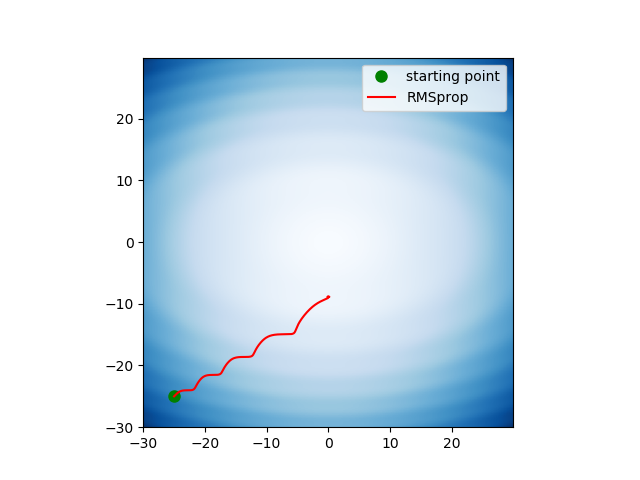

In [46]:
rmsprop = RMSprop(learning_rate, epsilon, gamma)

X = np.arange(-30, 30, 0.1)
Y = np.arange(-30, 30, 0.1)
cmap_plot_update(X, Y, ripple, ripple_der, rmsprop, -25, -25, iterations, "RMSprop")

We can see RMSprop is a big improvement.

### Adam

The [Adam (Adaptive Moment Estimation)](https://arxiv.org/pdf/1412.6980.pdf) is in essence the combination of RMSprop and momentum. This is one of the most common update rule right now.


Adam models momentum with:
$$ m_t = \beta_1 m_{t-1} + (1 - \beta_1) \nabla E_t$$

A similar term to RMSprop $G_t$:
$$ n_t = \beta_2 n_{t-1} + (1 - \beta_2)(\nabla E_t) ^ 2$$

The two terms are combined in the update rule:

$$\theta_{t+1} = \theta_t - \alpha \frac{\hat m_t}{\sqrt{\hat n_t} + \epsilon}$$

Where $\alpha$ is the learning rate, $\beta_1$ and $\beta_2$ are decay rates for momentum and RMSprop, $\epsilon$ is a small constant to prevent division by zero.

Since $m_0$ and $n_0$ are initialized to zeros. There is a tendency for these terms to be close to zeros at the start of training. The authors believes this bias toward zero need to be corrected with:

$$ \hat m_t = \frac{m_t}{1 - \beta_1^t}$$
$$ \hat n_t = \frac{n_t}{1 - \beta_2^t}$$



It is recommend by the author to set $\beta_1$ to $0.9$, $\beta_2$ to $0.999$, $\epsilon$ to $10^{\text{-}1}$.

In [47]:
class Adam:
    
    def __init__(self, alpha, beta1, beta2, epsilon):
        self.a = alpha
        self.b1 = beta1
        self.b2 = beta2
        self.eps = epsilon
        self.m = np.zeros(1)
        self.n = np.zeros(1)
        self.t = 1
    
    def __call__(self, x, der):
        self.m = self.b1 * self.m + (1 - self.b1) * der
        self.n = self.b2 * self.n + (1 - self.b2) * (der ** 2)
        m_hat = self.m / (1 - self.b1 ** self.t)
        n_hat = self.n / (1 - self.b2 ** self.t)
        self.t += 1
        return x - self.a * m_hat / (np.sqrt(n_hat) + self.eps)

<IPython.core.display.Javascript object>


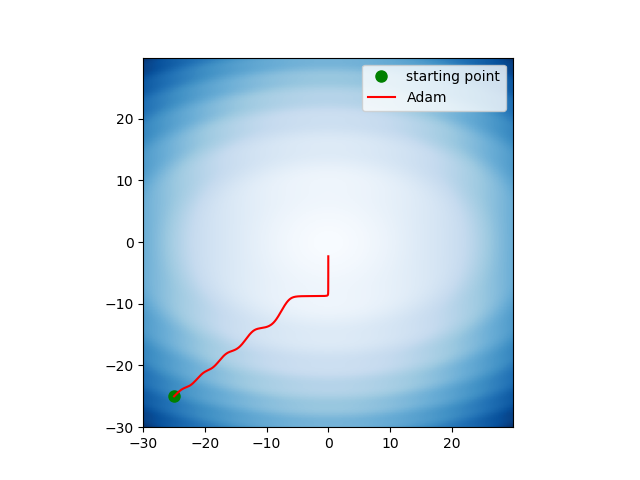

In [48]:
adam = Adam(0.1, 0.9, 0.999, 1e-8)

X = np.arange(-30, 30, 0.1)
Y = np.arange(-30, 30, 0.1)
cmap_plot_update(X, Y, ripple, ripple_der, adam, -25, -25, 1000, "Adam")

Since Adam adds momentum to RMSprop, there are less oscillations.

## Conclusion

What is presented here are just some of the more common training techniques, there are many different type of update rules, learning rate schedule, activation functions, etc. And other techniques that was not cover such as dropout, batch training, batch normalization, parameter initialization, ensembles of models, cyclical learning rate schedule, etc.  Neither was the theory and mathematics of these techniques covered in depth. I hope this lesson provides a jumping off point for exploring this topic.

## Solution

Solution to exercise 1:

It is possible for softmax to produce output value of 0. The log operation will turn 0 into negative infinity, which will overflow. This pose a numerical stability problem.

A possible fix is to ensure log operation never receive a input value of 0 by taking the maximum of 0 and the input value.